In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import time

tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape([-1, 28, 28, 1])
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape([-1, 28, 28, 1])
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

11493376/11490434 [==============================] - 0s 0us/step


label = 5


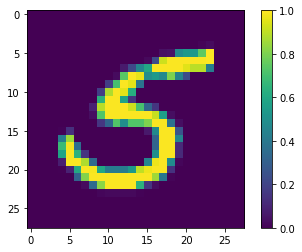

In [3]:
index = 219
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index][...,0])
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [0]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [5]:
tf.random.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

W0628 23:46:32.196507 140197260707712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<DatasetV1Adapter shapes: ((?, 28, 28, 1), (?, 10)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 28, 28, 1), (?, 10)), types: (tf.float32, tf.float32)>


In [0]:
model = tf.keras.Sequential()

In [0]:
model.add(layers.Conv2D(filters=32, kernel_size=[5, 5], padding='same', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(filters=64, kernel_size=[5, 5], padding='same', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [8]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  predictions = model(images[0:1], training=False)
  print("Predictions: ", predictions.numpy())

Predictions:  [[0.11348271 0.09540791 0.10029849 0.09661447 0.09375057 0.08816794
  0.10246772 0.09813071 0.10828694 0.10339257]]


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3212288   
_________________________________________________________________
dense_1 (Dense)              multiple                  1

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
acc_object = tf.keras.metrics.CategoricalAccuracy()

In [0]:
# use Adam optimizer 
optimizer = tf.train.AdamOptimizer(1e-4)

# record loss and accuracy for every epoch
mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Mean("accuracy")

# save loss and accuracy history for plot
loss_history = []
accuracy_history = [(0, 0.0)]

In [12]:
print("start training!")
global_step = tf.Variable(0, trainable=False)
num_batches_per_epoch = int(N / batch_size)

for epoch in range(max_epochs):
  
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss_value = loss_object(labels, predictions)
      acc_value = acc_object(labels, predictions)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    global_step.assign_add(1)
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    loss_history.append((global_step.numpy(), mean_loss.result().numpy()))

    if global_step.numpy() % 10 == 0:
      clear_output(wait=True)
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration) 
      print("epochs: {:.2f}, step: {}, loss: {:.3g}, accuracy: {:.4g}% ({:.2f} examples/sec; {:.4f} sec/batch)".format(
          epochs, global_step.numpy(), loss_value.numpy(), acc_value.numpy()*100, examples_per_sec, duration))
      
  # save mean accuracy for plot
  accuracy_history.append((global_step.numpy(), mean_accuracy.result().numpy()))

  # clear the history
  mean_accuracy.reset_states()

print("training done!")

epochs: 1.00, step: 1870, loss: 0.138, accuracy: 93.88% (1767.63 examples/sec; 0.0181 sec/batch)
training done!


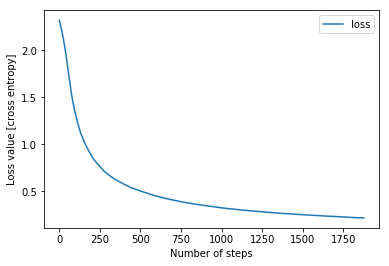

In [13]:
plt.plot(*zip(*loss_history), label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

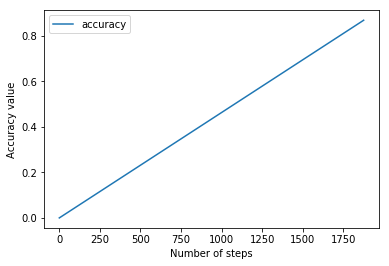

In [16]:
plt.plot(*zip(*accuracy_history), label='accuracy')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

In [0]:
accuracy = tf.keras.metrics.Accuracy()

for images, labels in test_dataset:
  predictions = model(images, training=False)
  accuracy(labels, tf.argmax(predictions, axis=1))
  
print("test accuracy: {:.4g}%".format(accuracy.result()))

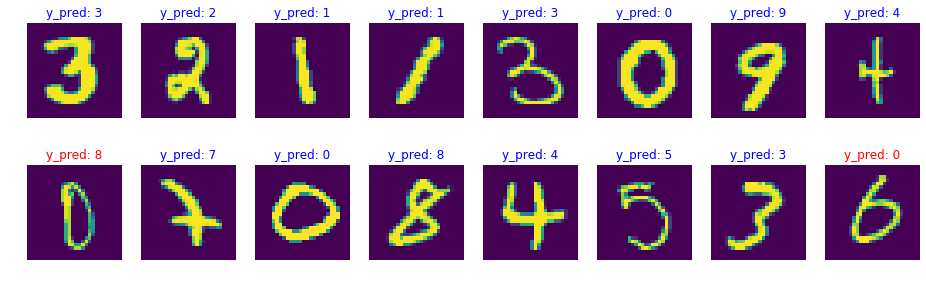

In [15]:
np.random.seed(219)
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')